# Partitioned Sampling Tests: 

In [ ]:
# using Distributed 
# addprocs(3)

In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests

In [2]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using Revise
using BAT

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1260


## 1. BAT model definition: Gaussian mixture

Let us use a mixture of 4 normal distribution with random  covariance matrices as a model: 

In [4]:
JLD2.@load "../data/mixture-5D.jld" means cov_m n_clusters

mixture_model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:1]);

In [5]:
prior = NamedTupleDist(a = [Uniform(-100,100) for i in 1:size(means)[2]])

# prior = NamedTupleDist(a = [Normal(0, 20) for i in 1:size(means)[2]])

likelihood = let model = mixture_model
    params -> begin
        return LogDVal(logpdf(model, params.a))
    end
end

posterior = PosteriorDensity(likelihood, prior);
log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

26.491586832740182

## 2. Sampling: 

In [6]:
sampler = MetropolisHastings() # AHMC()

burnin_1 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 5000,
        max_nsteps_per_cycle = 5000,
        max_time_per_cycle = 25,
        max_ncycles = 30
    )

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.05..0.15,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5
)

sampling_kwargs = (burnin = burnin_1,tuning=tuning);

The same with exploration sampler

In [7]:
# MetropolisHastings: 
exploration_sampler = MetropolisHastings()
burnin_2 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 5000,
        max_nsteps_per_cycle = 5000,
        max_time_per_cycle = 25,
        max_ncycles = 5
    )

exploration_kwargs = (burnin = burnin_1,)
n_exploration = (10^2, 40);

Space partitioning can be done using `BAT.KDTreePartitioning` algorithm

In [8]:
partitioner = KDTreePartitioning(
        partition_dims = [1,], # dimension indices that are considered for partition
        extend_bounds=true # "false" is appropriate for debugging, very fast tuning /convergence 
    );

To integrate subspaces, any `BAT.IntegrationAlgorithm` can be used: 

In [9]:
integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    );

In [10]:
algorithm = PartitionedSampling(
        sampler = sampler,
        exploration_sampler = exploration_sampler,
        partitioner = partitioner,
        integrator = integrator,
        exploration_kwargs = exploration_kwargs,
        sampling_kwargs = sampling_kwargs,
        n_exploration = n_exploration
    );

In [33]:
n_chains = 10 # chains per subspace 
n_samples = 10^4 # samples per subspace 
n_subspaces = 3

output_sp_ms = bat_sample(posterior, (n_samples, n_chains, n_subspaces), algorithm);

samples_3 = output_sp_ms.result;

┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:71
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 40 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 40 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 40 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info:

In [34]:
posterior_integral = -log(sum(output_sp_ms.info.density_integral))

25.509 ± 0.024

In [35]:
output_sp_ms.info.density_integral[1]

5.65e-12 ± 1.9e-13

In [36]:
log.(output_sp_ms.info.density_integral)

3-element Array{Measurement{Float64},1}:
 -25.899 ± 0.034
 -27.502 ± 0.028
 -27.185 ± 0.026

In [37]:
flat_bounds = BAT.get_tree_par_bounds(output_sp_ms.part_tree)

3-element Array{Array{Float64,N} where N,1}:
 [-100.0 -9.01038979303421; -100.0 100.0; … ; -100.0 100.0; -100.0 100.0]
 [-9.01038979303421 -3.945271799331991; -100.0 100.0; … ; -100.0 100.0; -100.0 100.0]
 [-3.945271799331991 100.0; -100.0 100.0; … ; -100.0 100.0; -100.0 100.0]

In [38]:
[sum(log.(rec_bound[:,2] .- rec_bound[:,1])) for rec_bound in flat_bounds]

3-element Array{Float64,1}:
 25.704014792640876
 22.815646899515272
 25.837133994125768

In [39]:
@show log(sum([prod(rec_bound[:,2] .- rec_bound[:,1]) for rec_bound in flat_bounds]))
@show log_volume;

log(sum([prod(rec_bound[:, 2] .- rec_bound[:, 1]) for rec_bound = flat_bounds])) = 26.491586832740182
log_volume = 26.491586832740182


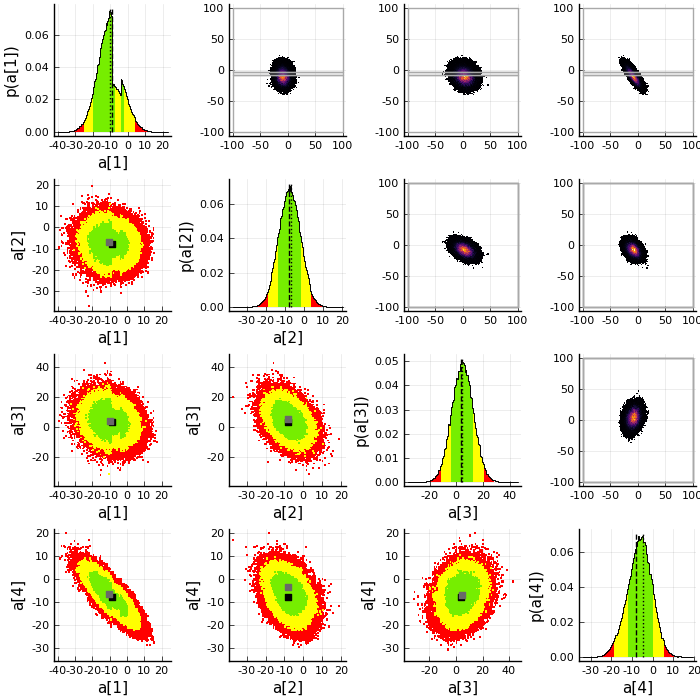

In [40]:
plot(samples_3, vsel=[1,2,3,4], size=(700,700), globalmode=true, localmode=true, 
    upper=Dict("partition_tree"=>output_sp_ms.part_tree, 
        "mean"=>false, "globalmode"=>false, "localmode"=>false))

## Test Subspaces: 

In [56]:
subs_ind = 1
smpl_ind = output_sp_ms.info.samples_ind[subs_ind]
smpl_tot_weight = output_sp_ms.info.sum_weights[subs_ind]
smpl_trunc = samples_3[smpl_ind]
smpl_int = output_sp_ms.info.density_integral[subs_ind].val

samples_tmp = DensitySampleVector((smpl_trunc.v,
            smpl_trunc.logd,
            round.(Integer, smpl_tot_weight .* smpl_trunc.weight ./ smpl_int),
            smpl_trunc.info,
            smpl_trunc.aux))


integral_val, hmi_data = bat_integrate(samples_tmp, integrator)

@show smpl_int, integral_val

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	50000 / 49999	Parameters:	5
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:117
┌ Info: Create Space Partitioning Tree
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:129
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:145
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:165
┌ Info: Create 69 Hyperrectangles using 8 thread(s)
└ @ 

(smpl_int, integral_val) = (5.6514302109379486e-12, 3.98e-12 ± 1.5e-13)


┌ Info: Updating 48 Hyperrectangles using 8 thread(s)
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 47 Hyperrectangles
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:384
┌ Warning: The batch contains zero samples. It's integral will be replaced with the average batch integral.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:470
┌ Warning: The batch contains zero samples. It's integral will be replaced with the average batch integral.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:470
┌ Warning: The batch contains zero samples. It's integral will be replaced with the average batch integral.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:470
┌ Warning: The batch contains zero samples. It's integral will be

(5.6514302109379486e-12, 3.98e-12 ± 1.5e-13)

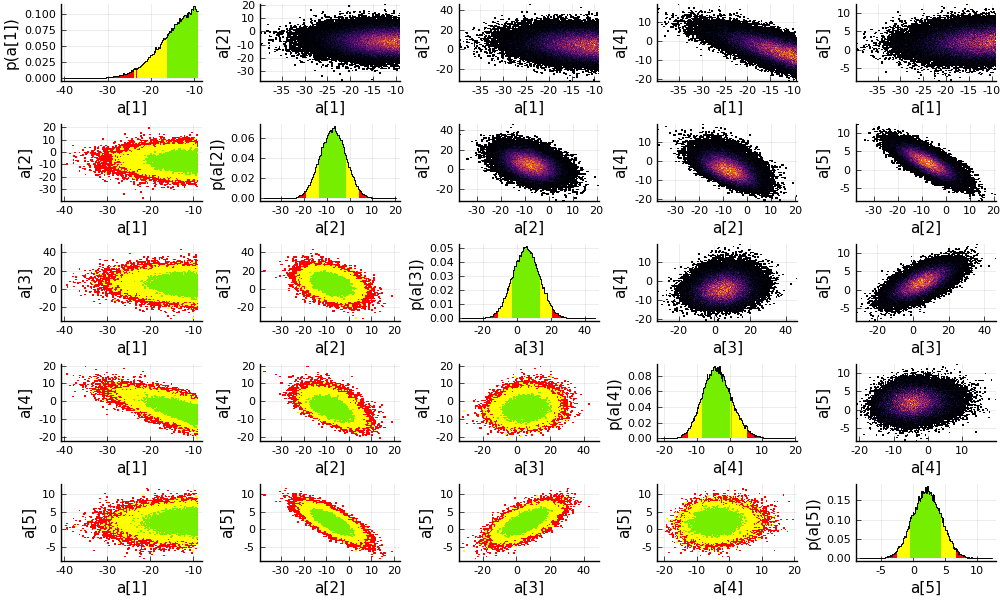

In [57]:
plot(samples_tmp)

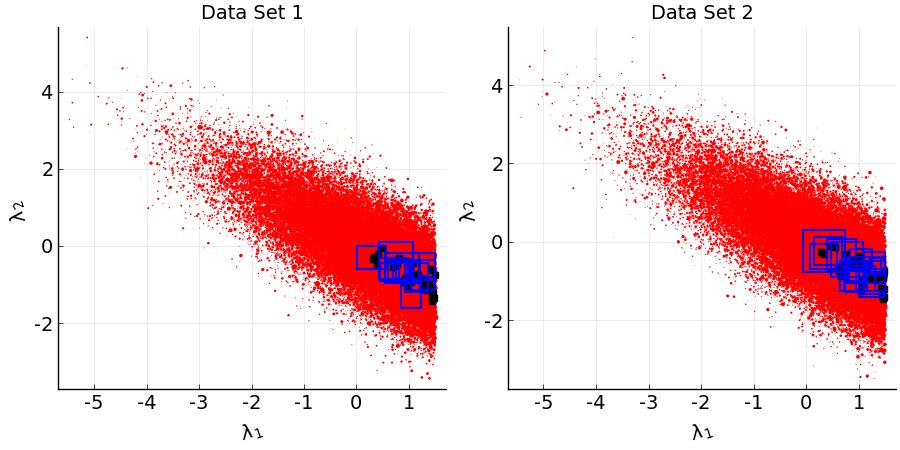

In [58]:
plot(hmi_data, dim1 = 1, dim2 = 2, size=(900,450), plot_seedcubes=false, plot_rejectedrects = false, plot_acceptedrects = true, legend=false)

## MCMC samples: 

In [59]:
output_mcmc = bat_sample(posterior, (10^5, n_chains), MetropolisHastings()).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 10 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 10 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 10 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl

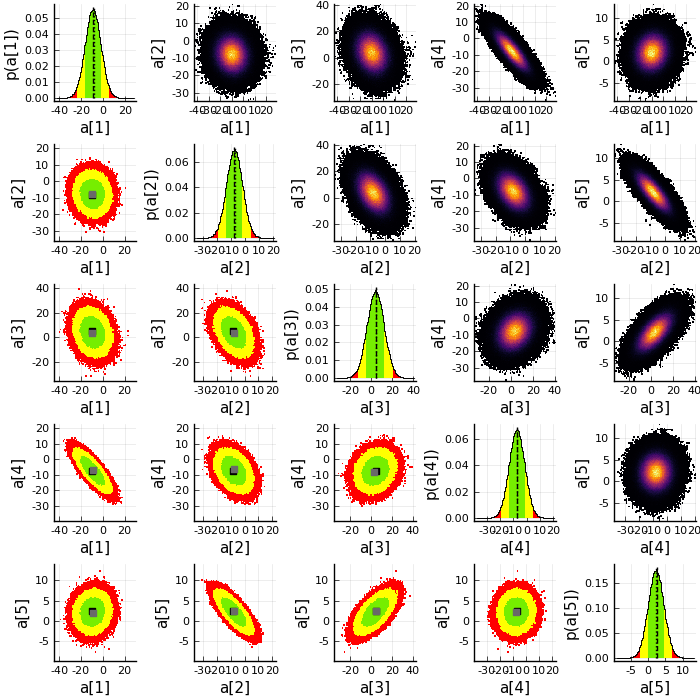

In [60]:
plot(output_mcmc, vsel=[1,2,3,4,5], size=(700,700), globalmode=true, localmode=true, 
    upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

In [61]:
log(bat_integrate(output_mcmc).result)

┌ Info: Using integration algorithm AHMIntegration{CholeskyPartialWhitening,GeyerAutocorLen}
│   whitening: CholeskyPartialWhitening CholeskyPartialWhitening()
│   autocorlen: GeyerAutocorLen GeyerAutocorLen()
│   volumetype: Symbol HyperRectangle
│   max_startingIDs: Int64 10000
│   max_startingIDs_fraction: Float64 2.5
│   rect_increase: Float64 0.1
│   warning_minstartingids: Int64 16
│   dotrimming: Bool true
│   uncertainty: Array{Symbol}((1,))
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	5
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_

-26.486 ± 0.0067